In [1]:
"""
Eksperyment: czy sekwencja przedłużona ma naturalny stop
Improvement: model powinien "wiedzieć", 
czy znajduje się w okolicy optimum lub czy potrzeba więcej informacji of funkcji celu
Eksperyment: wyznaczyć cosinusy pomiędzy wektorami w sekwencji (czy są współliniowe)
Eksperyment: wytrenować "jajowatego" transformera (patrz na kartkę od p. prof)
Improvement / Eksperyment? : zamienić wektory z przestrzeni n-wymiarowej na embeddingi 2d (kąt i długość wektora)
"""

'\nEksperyment: czy sekwencja przedłużona ma naturalny stop\nImprovement: model powinien "wiedzieć", \nczy znajduje się w okolicy optimum lub czy potrzeba więcej informacji of funkcji celu\nEksperyment: wyznaczyć cosinusy pomiędzy wektorami w sekwencji (czy są współliniowe)\nEksperyment: wytrenować "jajowatego" transformera (patrz na kartkę od p. prof)\nImprovement / Eksperyment? : zamienić wektory z przestrzeni n-wymiarowej na embeddingi 2d (kąt i długość wektora)\n'

In [2]:
"""
TODO:
1. napisać przegląd literatury
2. opis rozwiązania z transformerem - embedding, implementacja
3. opis eksperymentu związanego ze zbieżnością

- !! udostępnić tekst związany z opisem eksperymentu jak najszybciej !! (NA ZA TYDZIEN)

- sprawdzić macierze kowariancji czerwonego przebiegu (zaraz po stworzeniu populacji przez transformer) i niebieskiego 
- kryterium powstrzymania: zatrzymujemy jak się pogorszy jakość (np średniej kroczącej)
"""

'\nTODO:\n1. napisać przegląd literatury\n2. opis rozwiązania z transformerem - embedding, implementacja\n3. opis eksperymentu związanego ze zbieżnością\n\n- !! udostępnić tekst związany z opisem eksperymentu jak najszybciej !! (NA ZA TYDZIEN)\n\n- sprawdzić macierze kowariancji czerwonego przebiegu (zaraz po stworzeniu populacji przez transformer) i niebieskiego \n- kryterium powstrzymania: zatrzymujemy jak się pogorszy jakość (np średniej kroczącej)\n'

In [16]:
import torch
import numpy as np
import benchmark_functions as bf
import matplotlib.pyplot as plt

from src.transformer.test import TransformerModel

In [4]:
from src.evolution.entities import Point
from src.evolution.algorithms import Evolution
from src.evolution.graph_utils import create_graph_from_last_population


def mutation_fun(coords: np.array, population_coords: np.array):
    mean = 0.0
    std_dev = mutation_std_dev
    gaussian_noise = np.random.normal(mean, std_dev, size=coords.shape)
    return coords + 1.0 * gaussian_noise


def run_evolution(dim, pop_size, target, population_mean, scale, iter_num):
    target_fun = target(n_dimensions=dim)
    
    start_population = [
        Point(
            coordinates=np.random.normal(size=dim, loc=population_mean, scale=scale),
            target_fun=target_fun)
        for _ in range(pop_size)
    ]
    
    ev = Evolution(
        population=start_population,
        mutate_fun=mutation_fun,
        elitist=False
    )
    
    ev.run(iter_num)
    graph_trimmed = create_graph_from_last_population(ev.population)
    return ev, graph_trimmed

In [5]:
from copy import deepcopy
import pandas as pd
from typing import List, Tuple


def vectors_to_token(current_vector, prev_vector):
    cosine_sim = np.dot(current_vector, prev_vector)/(np.linalg.norm(current_vector)*np.linalg.norm(prev_vector))
    return (cosine_sim, np.linalg.norm(current_vector))

def tree_to_token_sequence(G):
    # Identify all leaf nodes
    leaf_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    # Find the leaf node with the lowest fitness value
    min_fitness_leaf = min(leaf_nodes, key=lambda node: G.nodes[node]['fitness'])

    # Find the path from the root to this leaf node
    root = next(node for node in G.nodes if G.in_degree(node) == 0)
    path = nx.shortest_path(G, source=root, target=min_fitness_leaf)
    
    vectors = []
    for i, point in enumerate(path):
        if i == 0:
            continue
        parent_coords = G.nodes[path[i-1]]['coordinates']
        current_coords = G.nodes[point]['coordinates']
        vectors.append(current_coords - parent_coords)

    sequence = []
    for i, vector in enumerate(vectors):
        if i == 0:
            continue
        sequence.append(vectors_to_token(vector, vectors[i-1]))
    
    return sequence


def str_to_np_array(s):
    arr = s.strip('[]').split()
    arr = np.array([float(item) for item in arr])
    return arr

def get_populations_means(population_log: pd.DataFrame) -> List[np.ndarray]:
    # population_log = deepcopy(population_log)
    # population_log['coordinates'] = population_log['coordinates'].apply(lambda x: str_to_np_array(x))
    means = population_log.groupby(by='population_num')['coordinates'].mean().to_list()
    population_log
    return means

def points_to_vectors(points: List[np.ndarray]) -> List[np.ndarray]:
    vectors = []
    for i, point in enumerate(points):
        if i == 0:
            continue
        vectors.append(point - points[i-1])
    return vectors

def population_log_to_token_sequence(population_log: pd.DataFrame) -> List[Tuple]:
    means = get_populations_means(population_log)
    vectors = points_to_vectors(means)
    sequence = []
    for i, vector in enumerate(vectors):
        if i == 0:
            continue
        sequence.append(vectors_to_token(vector, vectors[i-1]))
    return sequence

In [6]:
def continue_sequence(model, input_sequence, continuation_length=10):
    """
    Continues an input sequence using a trained transformer model that requires src and tgt inputs.
    
    :param model: Trained transformer model
    :param input_sequence: ndarray shape (seq_len, 10)
    :param continuation_length: Number of steps to continue
    :return: Continued sequence of shape (seq_len + continuation_length, 10)
    """
    # Create an initial tgt sequence with the same length as input_sequence
    input_sequence = torch.Tensor(input_sequence)
    tgt_sequence = input_sequence.clone()
    
    with torch.no_grad():
        for _ in range(continuation_length):
            # Prepare src and tgt for the model
            src = input_sequence.unsqueeze(0).permute(1, 0, 2)  # Add batch dimension to src
            tgt = tgt_sequence.unsqueeze(0).permute(1, 0, 2)    # Add batch dimension to tgt
    
            # Predict the next step
            next_step = model(src, tgt)[-1, :, :]  # Take the last time step's prediction
    
            # Concatenate the next step to the tgt sequence
            tgt_sequence = torch.cat((tgt_sequence, next_step), dim=0)
    return tgt_sequence.numpy()

In [7]:
def generate_vector(v, norm_ratio, cosine_similarity):
    norm_v = np.linalg.norm(v)
    v_normalized = v / norm_v  # Normalize v

    norm_u = norm_ratio * norm_v
    # Parallel component
    u_parallel = cosine_similarity * norm_u * v_normalized
    
    # Find an orthogonal vector to v
    if np.all(v == 0):
        raise ValueError("The input vector v is zero vector, can't define direction.")
    
    # Generate a random vector and make it orthogonal to v
    random_vector = np.random.randn(*v.shape)
    orthogonal_vector = random_vector - np.dot(random_vector, v_normalized) * v_normalized
    orthogonal_vector = orthogonal_vector / np.linalg.norm(orthogonal_vector)  # Normalize it
    
    # Perpendicular component (u_perp)
    u_perp = np.sqrt(1 - cosine_similarity**2) * norm_u * orthogonal_vector
    
    u = u_parallel + u_perp
    return u
    

def get_point(sp, v):
    position = sp + v
    # fitness = obj_fun(position)
    return position

def get_sequence_of_points(sp, vectors):
    seq = [sp]
    for vector in vectors:
        next_point = get_point(sp, vector)
        seq.append(next_point)
        
        sp = next_point
    return seq

def get_sequence_of_vectors(sv, embeddings):
    seq = [sv]
    for embedding in embeddings:
        cosine_sim, u_norm = embedding[0], embedding[1]
        next_vector = generate_vector(sv, u_norm, cosine_sim)
        seq.append(next_vector)
        
        sp = next_vector
    return seq

def get_sequence_of_fitness(points, obj_fun):
    return [obj_fun(point.astype(float)) for point in points]

# Testing continuation quality

In [7]:
model_name = 'model_40c52fd9-0797-480b-b884-6d74da285816_egg_50.pth'
model_dir = 'models/' + model_name
model = torch.load(model_dir)

In [8]:
iter_num = 20

dim = 10
mutation_std_dev = 10.0
pop_size = 20
target = bf.Hypersphere


population_mean = np.random.rand(dim) * 1000
scale = 10.0

continuation_length = 20

In [9]:
from tqdm import tqdm

fitness_diff = []
original_finals = []
transformer_finals = []
origins = []

for _ in tqdm(range(50)):
    ev, graph_trimmed = run_evolution(dim, pop_size, target, population_mean, scale, iter_num = iter_num + continuation_length)
    
    population_log =ev.population_log_to_df()
    input_log = population_log.iloc[:iter_num*pop_size]
    
    input_points = get_populations_means(input_log)
    input_vectors = points_to_vectors(input_points)
    input_sequence = population_log_to_token_sequence(input_log)
    
    output_sequence = continue_sequence(
        model, 
        input_sequence=input_sequence,
        continuation_length=continuation_length
    )[-continuation_length:]
    
    total_vectors = input_vectors + get_sequence_of_vectors(sv=input_vectors[-1], embeddings=output_sequence)
    
    points = get_sequence_of_points(sp=input_points[0], vectors=total_vectors)
    fitnesses = get_sequence_of_fitness(points, obj_fun)[-continuation_length:]
    fitness_diff.append((fitnesses[0] - fitnesses[-1])/fitnesses[0])

    original_fitnesses = get_sequence_of_fitness(get_populations_means(population_log), obj_fun)

    original_finals.append(original_fitnesses[-1])
    transformer_finals.append(fitnesses[-1])
    origins.append(original_fitnesses[iter_num])
    

fitness_diff

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


NameError: name 'obj_fun' is not defined

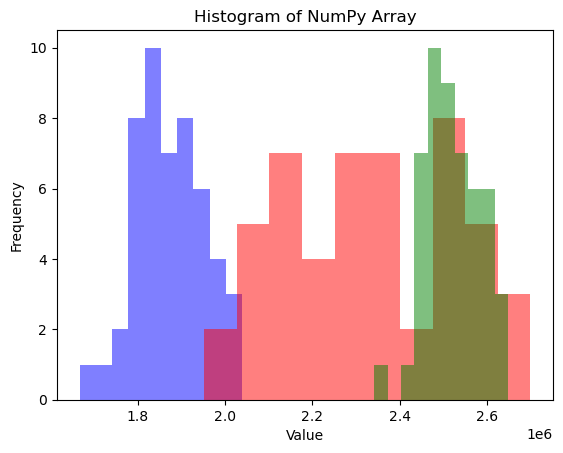

In [65]:
import matplotlib.pyplot as plt

# plt.hist(fitness_diff, bins='auto', edgecolor='black')
plt.hist(original_finals, bins=10, alpha=0.5, label='Data 1', color='blue')
plt.hist(transformer_finals, bins=10, alpha=0.5, label='Data 2', color='red')
plt.hist(origins, bins=10, alpha=0.5, label='Data 2', color='green')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of NumPy Array')
plt.show()

# Combined algorithms

In [8]:
"""
TODO:
Metoda 0: algorytm ewolucyjny
Metoda 1: transformer wyznacza punkt środkowy populacji a następnie przesuwamy populację o wektor wyznaczony przez transformer
Metoda 2: transformer oddzielnie wyznacza punkty populacji za pomocą niezależnych uruchomień ( tyle jaka jest liczebnośc populacji)

Metryki: 
- krzywa zbieżności punktu środkowego oraz jakości najlepszego punktu dotąd znalezionego
   - oś x: liczba obliczeń funcji celu
- krzywa ECDF (? opcjonalne ?)
"""

'\nTODO:\nMetoda 0: algorytm ewolucyjny\nMetoda 1: transformer wyznacza punkt środkowy populacji a następnie przesuwamy populację o wektor wyznaczony przez transformer\nMetoda 2: transformer oddzielnie wyznacza punkty populacji za pomocą niezależnych uruchomień ( tyle jaka jest liczebnośc populacji)\n\nMetryki: \n- krzywa zbieżności punktu środkowego oraz jakości najlepszego punktu dotąd znalezionego\n   - oś x: liczba obliczeń funcji celu\n- krzywa ECDF (? opcjonalne ?)\n'

In [9]:
def run_evolution_from_start_population(start_population, mutation_fun, iter_num):
    ev = Evolution(
        population=start_population,
        mutate_fun=mutation_fun,
        elitist=False
    )
    
    ev.run(iter_num)
    # graph_trimmed = create_graph_from_last_population(ev.population)
    return ev

In [27]:
# get the model

model_name = 'model_40c52fd9-0797-480b-b884-6d74da285816_egg_50.pth'
# model_name = 'model_786d4513-93f4-4cf5-8ca4-6364541b600a_egg_50.pth'
model_dir = 'models/' + model_name
MODEL = torch.load(model_dir)

In [28]:
from src.evolution.objective_funs import EggFunction

# run parameters

DIM = 10
MUTATION_STD_DEV = 10.0
POP_SIZE = 20
TARGET = EggFunction

TARGET_FUN = TARGET(n_dimensions=DIM, attributes=np.random.uniform(1, 10, DIM))

def mutation_fun(coords: np.array, population_coords: np.array):
    mean = 0.0
    std_dev = MUTATION_STD_DEV
    gaussian_noise = np.random.normal(mean, std_dev, size=coords.shape)
    return coords + 1.0 * gaussian_noise
    

WINDOW_LEN = 20
CONTINUATION_LEN = 20
TOTAL_ITERATIONS = 500

In [29]:
# Start population

population_mean = np.random.rand(DIM) * 1000
scale = 10.0

START_POP = [
    Point(
        coordinates=np.random.normal(size=DIM, loc=population_mean, scale=scale),
        target_fun=TARGET_FUN)
    for _ in range(POP_SIZE)
]

In [30]:
def run_only_evolution(obj_fun, starting_population, mutation_fun, iter_num):
    ev = run_evolution_from_start_population(starting_population, mutation_fun, iter_num)
    pop_log = ev.population_log_to_df()
    pop_means = get_populations_means(pop_log)
    
    means_fitnesses = get_sequence_of_fitness(pop_means, obj_fun)
    return means_fitnesses

def run_variant_1(obj_fun, starting_population, mutation_fun, total_iters, window_len, continuation_len):
    """
    transformer wyznacza punkt środkowy populacji a następnie przesuwamy populację o wektor wyznaczony przez transformer
    """
    total_fitnesses = []
    for cycle in range(int(total_iters/(window_len))):
        ev = run_evolution_from_start_population(starting_population, mutation_fun, window_len)
        population_log =ev.population_log_to_df()
        input_log = population_log.iloc[:window_len*len(starting_population)]
        input_points = get_populations_means(input_log)
        total_fitnesses += get_sequence_of_fitness(input_points, obj_fun)
        
        input_vectors = points_to_vectors(input_points)
        input_sequence = population_log_to_token_sequence(input_log)
        
        output_sequence = continue_sequence(
            MODEL, 
            input_sequence=input_sequence,
            continuation_length=continuation_len
        )[-continuation_len:]
        
        output_vectors = get_sequence_of_vectors(sv=input_vectors[-1], embeddings=output_sequence)
        cumulative_vector = np.array(output_vectors).sum(axis=0)

        starting_population = [
            Point(
                coordinates=point.coordinates + cumulative_vector,
                target_fun=obj_fun)
            for point in ev.population
        ]

    return total_fitnesses

def run_variant_2(obj_fun, starting_population, mutation_fun, total_iters, window_len, continuation_len):
    """
    transformer oddzielnie wyznacza punkty populacji za pomocą niezależnych uruchomień ( tyle jaka jest liczebnośc populacji)
    """
    total_fitnesses = []
    for cycle in range(int(total_iters/(window_len))):
        ev = run_evolution_from_start_population(starting_population, mutation_fun, window_len)
        population_log =ev.population_log_to_df()
        input_log = population_log.iloc[:window_len*len(starting_population)]
        input_points = get_populations_means(input_log)
        total_fitnesses += get_sequence_of_fitness(input_points, obj_fun)
        
        input_vectors = points_to_vectors(input_points)
        input_sequence = population_log_to_token_sequence(input_log)
        
        output_sequence = continue_sequence(
            MODEL, 
            input_sequence=input_sequence,
            continuation_length=continuation_len
        )[-continuation_len:]

        starting_population = []
        for point in ev.population:
            output_vectors = get_sequence_of_vectors(sv=input_vectors[-1], embeddings=output_sequence)
            cumulative_vector = np.array(output_vectors).sum(axis=0)
    
            starting_population.append(
                Point(
                    coordinates=point.coordinates + cumulative_vector,
                    target_fun=obj_fun
                ))

    return total_fitnesses

In [31]:
# def compress_points(points, desired_variance):
#     mean = np.mean(points, axis=0)
#     centered_points = points - mean
#     current_variance = np.var(centered_points, ddof=0)
#     scaling_factor = np.sqrt(desired_variance / current_variance)
#     scaled_points = centered_points * scaling_factor
#     compressed_points = scaled_points + mean
#     return compressed_points

def compress_points(points, desired_total_distance):
    mean_vector = np.mean(points, axis=0)
    distances = np.linalg.norm(points - mean_vector, axis=1)
    current_total_distance = np.sum(distances)
    scaling_factor = desired_total_distance / current_total_distance
    compressed_points = mean_vector + (points - mean_vector) * scaling_factor
    return compressed_points
    

def run_variant_3(model, obj_fun, starting_population, mutation_fun, total_iters, window_len, continuation_len):
    """
    transformer oddzielnie wyznacza punkty populacji za pomocą niezależnych uruchomień ( tyle jaka jest liczebnośc populacji)
    """
    total_fitnesses = []
    for cycle in range(int(total_iters / (window_len))):
        ev = run_evolution_from_start_population(starting_population, mutation_fun, window_len)
        population_log = ev.population_log_to_df()
        input_log = population_log.iloc[:window_len * len(starting_population)]
        input_points = get_populations_means(input_log)
        total_fitnesses += get_sequence_of_fitness(input_points, obj_fun)

        input_vectors = points_to_vectors(input_points)
        input_sequence = population_log_to_token_sequence(input_log)

        output_sequence = continue_sequence(
            model,
            input_sequence=input_sequence,
            continuation_length=continuation_len
        )[-continuation_len:]

        
        scattered_points = []
        for point in ev.population:
            output_vectors = get_sequence_of_vectors(sv=input_vectors[-1], embeddings=output_sequence)
            cumulative_vector = np.array(output_vectors).sum(axis=0)
            scattered_points.append(point.coordinates + cumulative_vector)
        scattered_points = np.array(scattered_points)

        
        coords = np.array([point.coordinates for point in ev.population])
        mean_vector = np.mean(coords, axis=0)
        distances = np.linalg.norm(coords - mean_vector, axis=1)
        total_distance = sum(distances)
        
        compressed_points = compress_points(scattered_points, total_distance)

        starting_population = []
        for point in compressed_points:
            starting_population.append(
                Point(
                    coordinates=point,
                    target_fun=obj_fun
                ))
        
    return total_fitnesses

In [32]:
# def get_covariance(obj_fun, starting_population, mutation_fun, total_iters, window_len, continuation_len):
#     ev = run_evolution_from_start_population(starting_population, mutation_fun, window_len)
#     population_log =ev.population_log_to_df()
#     input_log = population_log.iloc[:window_len*len(starting_population)]
#     input_points = get_populations_means(input_log)
    
#     input_vectors = points_to_vectors(input_points)
#     input_sequence = population_log_to_token_sequence(input_log)
    
#     output_sequence = continue_sequence(
#         MODEL, 
#         input_sequence=input_sequence,
#         continuation_length=continuation_len
#     )[-continuation_len:]

#     starting_population = []
#     for point in ev.population:
#         output_vectors = get_sequence_of_vectors(sv=input_vectors[-1], embeddings=output_sequence)
#         cumulative_vector = np.array(output_vectors).sum(axis=0)

#         starting_population.append(
#             Point(
#                 coordinates=point.coordinates + cumulative_vector,
#                 target_fun=obj_fun
#             ))
#     v2_array_list = [point.coordinates for point in starting_population]
#     v2_stacked_array = np.vstack(v2_array_list)
#     v2_cov_matrix = np.cov(v2_stacked_array, rowvar=False)

#     ev_array_list = [point.coordinates for point in ev.population]
#     ev_stacked_array = np.vstack(ev_array_list)
#     ev_cov_matrix = np.cov(ev_stacked_array, rowvar=False)

#     return v2_cov_matrix, ev_cov_matrix

# v2_cov, ev_cov = get_covariance(
#     obj_fun=TARGET_FUN, 
#     starting_population=START_POP, 
#     mutation_fun=mutation_fun, 
#     total_iters=TOTAL_ITERATIONS, 
#     window_len=WINDOW_LEN, 
#     continuation_len=CONTINUATION_LEN
# )

# plt.imshow(v2_cov - ev_cov, cmap='viridis', interpolation='nearest')
# plt.colorbar()

In [36]:
# run_only_evolution(
#     starting_population=START_POP, 
#     mutation_fun=mutation_fun, 
#     iter_num=TOTAL_ITERATIONS, 
#     obj_fun=TARGET_FUN
# )

run_variant_3(
    model=MODEL,
    obj_fun=TARGET_FUN, 
    starting_population=START_POP, 
    mutation_fun=mutation_fun, 
    total_iters=TOTAL_ITERATIONS, 
    window_len=WINDOW_LEN, 
    continuation_len=CONTINUATION_LEN
)

[7792064.62020296,
 7650481.376174815,
 7610755.791526537,
 7522512.564245028,
 7410349.579209801,
 7178333.3518705,
 7074651.4405786125,
 6938280.25812081,
 6728757.175186975,
 6625442.030371392,
 6481736.820812716,
 6332257.568100365,
 6276585.644409606,
 6147227.788359772,
 6049703.577596819,
 5922478.322389528,
 5817336.1961776335,
 5721791.334594751,
 5635048.682980336,
 5571367.913237896,
 5379624.999751862,
 5245871.256318723,
 5167527.031090839,
 5112204.461544728,
 5019646.8525656825,
 4914908.42490695,
 4808038.881221288,
 4689561.339911878,
 4560786.296142939,
 4499555.294981763,
 4441652.52174205,
 4356376.325186737,
 4275500.093315485,
 4189269.5414038426,
 4125868.2493473846,
 4026011.7183022476,
 3906857.246570987,
 3761570.8015496307,
 3678290.841892275,
 3573708.9758719956,
 3407210.5763425985,
 3275421.8171558566,
 3148640.5164740463,
 3047716.310896679,
 2938630.037798576,
 2844264.497553771,
 2712742.508464822,
 2603764.3648251775,
 2524127.469515036,
 2468881.53720

In [38]:
import matplotlib.pyplot as plt
from tqdm import tqdm


plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
v0s = []
v1s = []
v2s = []
for _ in tqdm(range(3)):
    
    v0 = run_only_evolution(
        starting_population=START_POP, 
        mutation_fun=mutation_fun, 
        iter_num=TOTAL_ITERATIONS, 
        obj_fun=TARGET_FUN
    )

    # v1 = run_variant_1(
    #     obj_fun=TARGET_FUN, 
    #     starting_population=START_POP, 
    #     mutation_fun=mutation_fun, 
    #     total_iters=TOTAL_ITERATIONS, 
    #     window_len=WINDOW_LEN, 
    #     continuation_len=CONTINUATION_LEN
    # )

    v1 = run_variant_3(
        model=MODEL,
        obj_fun=TARGET_FUN, 
        starting_population=START_POP, 
        mutation_fun=mutation_fun, 
        total_iters=TOTAL_ITERATIONS, 
        window_len=WINDOW_LEN, 
        continuation_len=CONTINUATION_LEN
    )
    
    v2 = run_variant_2(
        obj_fun=TARGET_FUN, 
        starting_population=START_POP, 
        mutation_fun=mutation_fun, 
        total_iters=TOTAL_ITERATIONS, 
        window_len=WINDOW_LEN, 
        continuation_len=CONTINUATION_LEN
    )

    v0s.append(v0)
    v1s.append(v1)
    v2s.append(v2)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:04<00:00, 41.43s/it]


<Figure size 1000x600 with 0 Axes>

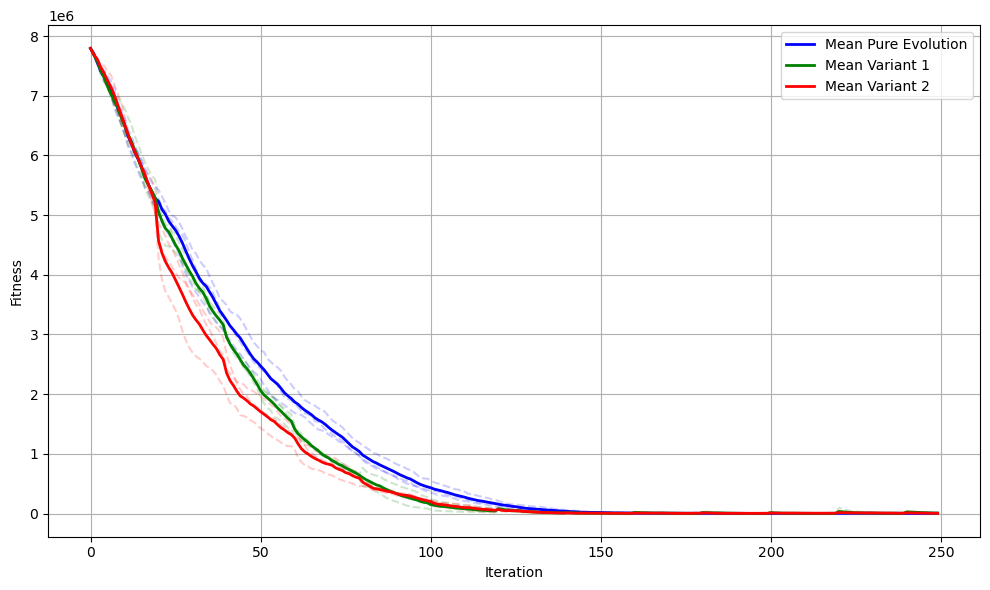

In [39]:
iter_cutoff = 250

plt.figure(figsize=(10, 6))

# Preparing data arrays to store all iterations for mean calculation
all_v0s = np.array([v[:iter_cutoff] for v in v0s])
all_v1s = np.array([v[:iter_cutoff] for v in v1s])
all_v2s = np.array([v[:iter_cutoff] for v in v2s])

# Calculate mean of all iterations for each variant
mean_v0 = np.mean(all_v0s, axis=0)
mean_v1 = np.mean(all_v1s, axis=0)
mean_v2 = np.mean(all_v2s, axis=0)

# Plot each line with reduced alpha
for i in range(len(v0s)):
    plt.plot(v0s[i][:iter_cutoff], linestyle='--', color='b', alpha=0.2)
    plt.plot(v1s[i][:iter_cutoff], linestyle='--', color='g', alpha=0.2)
    plt.plot(v2s[i][:iter_cutoff], linestyle='--', color='r', alpha=0.2)

# Plot mean lines with full opacity and labels
plt.plot(mean_v0, linestyle='-', color='b', label='Mean Pure Evolution', linewidth=2)
plt.plot(mean_v1, linestyle='-', color='g', label='Mean Variant 1', linewidth=2)
plt.plot(mean_v2, linestyle='-', color='r', label='Mean Variant 2', linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('Fitness')

plt.legend()
plt.grid(True)
plt.tight_layout()

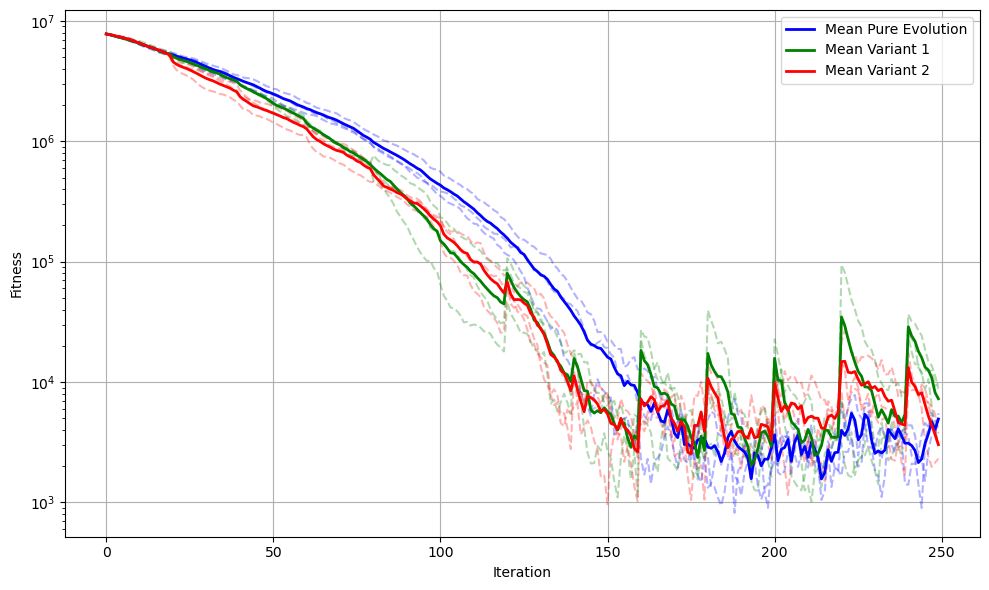

In [40]:
import matplotlib.pyplot as plt
import numpy as np

iter_cutoff = 250

plt.figure(figsize=(10, 6))

# Preparing data arrays to store all iterations for mean calculation
all_v0s = np.array([v[:iter_cutoff] for v in v0s])
all_v1s = np.array([v[:iter_cutoff] for v in v1s])
all_v2s = np.array([v[:iter_cutoff] for v in v2s])

# Calculate mean of all iterations for each variant
mean_v0 = np.mean(all_v0s, axis=0)
mean_v1 = np.mean(all_v1s, axis=0)
mean_v2 = np.mean(all_v2s, axis=0)

# Plot each line with reduced alpha
for i in range(len(v0s)):
    plt.plot(v0s[i][:iter_cutoff], linestyle='--', color='b', alpha=0.3)
    plt.plot(v1s[i][:iter_cutoff], linestyle='--', color='g', alpha=0.3)
    plt.plot(v2s[i][:iter_cutoff], linestyle='--', color='r', alpha=0.3)

# Plot mean lines with full opacity and labels
plt.plot(mean_v0, linestyle='-', color='b', label='Mean Pure Evolution', linewidth=2)
plt.plot(mean_v1, linestyle='-', color='g', label='Mean Variant 1', linewidth=2)
plt.plot(mean_v2, linestyle='-', color='r', label='Mean Variant 2', linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd

def find_stability_point(values, window=30, percentage_threshold=0.005, min_iteration=50):
    # Calculate the moving average
    moving_avg = pd.Series(values).rolling(window=window, min_periods=1).mean()
    
    # Calculate dynamic threshold as a percentage of the moving average
    dynamic_threshold = moving_avg * percentage_threshold
    
    # Ensure we only start checking from at least the specified minimum iteration
    valid_range_start = max(min_iteration, window)  # Ensure we have enough data for the moving average to be meaningful

    # Find the point where changes become smaller than the dynamic threshold, only considering iterations after min_iteration
    stable_points = np.flatnonzero(np.abs(np.diff(moving_avg[valid_range_start:])) < dynamic_threshold[valid_range_start:-1])
    
    if len(stable_points) > 0:
        return valid_range_start + stable_points[0] + 1  # Adjust for the offset caused by limiting the range
    else:
        return len(values)  # If no stability point is found, return the last iteration

# Initialize lists to collect smallest values and stability points
min_values = {'v0': [], 'v1': [], 'v2': []}
stability_points = {'v0': [], 'v1': [], 'v2': []}

# Process each variant
for variant_data, key in zip([v0s, v1s, v2s], ['v0', 'v1', 'v2']):
    for series in variant_data:
        truncated_series = series
        min_values[key].append(np.min(truncated_series))
        stability_points[key].append(find_stability_point(truncated_series))

# Calculate the mean of the smallest values and mean stability points for each variant
mean_smallest_values = {k: np.mean(v) for k, v in min_values.items()}
mean_stability_points = {k: np.mean(v) for k, v in stability_points.items()}

print("Mean of the smallest recorded values for each variant:", mean_smallest_values)
print("Mean iteration number for reaching stability for each variant:", mean_stability_points)


Mean of the smallest recorded values for each variant: {'v0': 921.4398653086431, 'v1': 1253.241871972768, 'v2': 1012.0727100189445}
Mean iteration number for reaching stability for each variant: {'v0': 269.3, 'v1': 254.1, 'v2': 242.9}


\begin{tabular}{lrrrrrr}
\toprule
Function & \multicolumn{2}{r}{Rastrigin} & \multicolumn{2}{r}{Auckley} & \multicolumn{2}{r}{Egg} \\
Metric & Mean Smallest & Mean Stability & Mean Smallest & Mean Stability & Mean Smallest & Mean Stability \\
\midrule
v0 & 956.674508 & 230.000000 & 1.674508 & 20.000000 & 1.674508 & 20.000000 \\
v1 & 1633.337812 & 219.500000 & 16.337812 & 21.500000 & 16.337812 & 21.500000 \\
v2 & 968.189530 & 220.500000 & 96.189530 & 20.500000 & 96.189530 & 20.500000 \\
\bottomrule
\end{tabular}



In [46]:
import os
import json

def read_json_files(directory):
    results = []
    # List all files in the given directory
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                # Load JSON data from the file
                data = json.load(file)
                
                # Extract the name from the filename (assuming the pattern "<name>_<params>.json")
                name = filename.split('_')[0]
                
                # Append the data in the required format
                results.append({
                    "name": name,
                    "mean_smallest": data["mean_smallest"],
                    "mean_stability": data["mean_stability"]
                })
    return results

# Specify the directory containing the JSON files
directory = "results/model_40c52fd9-0797-480b-b884-6d74da285816_egg_50.pth/data"
data = read_json_files(directory)
data

[{'name': 'Ackley',
  'mean_smallest': {'v0': 20.874777439901067,
   'v1': 20.865766768506106,
   'v2': 20.867022642670992},
  'mean_stability': {'v0': 51.0, 'v1': 51.0, 'v2': 51.0}},
 {'name': 'EggFunction',
  'mean_smallest': {'v0': 750.4166371571854,
   'v1': 1240.9717183208754,
   'v2': 1019.8470001165942},
  'mean_stability': {'v0': 211.1, 'v1': 178.1, 'v2': 168.6}},
 {'name': 'Hypersphere',
  'mean_smallest': {'v0': 159.49202698068683,
   'v1': 190.77045681725403,
   'v2': 182.49923555275114},
  'mean_stability': {'v0': 180.1, 'v1': 170.0, 'v2': 158.9}},
 {'name': 'Rastrigin',
  'mean_smallest': {'v0': 268.9367646432237,
   'v1': 301.09084146363546,
   'v2': 251.57928412475044},
  'mean_stability': {'v0': 241.0, 'v1': 225.9, 'v2': 208.0}},
 {'name': 'Rosenbrock',
  'mean_smallest': {'v0': 620776.2550032574,
   'v1': 1651790.890747869,
   'v2': 1698062.5021929084},
  'mean_stability': {'v0': 203.4, 'v1': 186.9, 'v2': 185.3}}]

In [47]:
# Create the multi-level DataFrame with modified column names
functions = [d["name"] for d in data]
metrics = ["Mean Smallest", "Mean Stability"]
columns = pd.MultiIndex.from_product([functions, metrics], names=['Function', 'Metric'])
index = ["v0", "v1", "v2"]

# Extract values for each index
values = []
for idx in index:
    row = []
    for function in data:
        row.append(function["mean_smallest"][idx])
        row.append(function["mean_stability"][idx])
    values.append(row)

# Generate the DataFrame
df = pd.DataFrame(values, columns=columns, index=index)

# Display the DataFrame
df


Function        Ackley                  EggFunction                 \
Metric   Mean Smallest Mean Stability Mean Smallest Mean Stability   
v0           20.874777           51.0    750.416637          211.1   
v1           20.865767           51.0   1240.971718          178.1   
v2           20.867023           51.0   1019.847000          168.6   

Function   Hypersphere                    Rastrigin                 \
Metric   Mean Smallest Mean Stability Mean Smallest Mean Stability   
v0          159.492027          180.1    268.936765          241.0   
v1          190.770457          170.0    301.090841          225.9   
v2          182.499236          158.9    251.579284          208.0   

Function    Rosenbrock                 
Metric   Mean Smallest Mean Stability  
v0        6.207763e+05          203.4  
v1        1.651791e+06          186.9  
v2        1.698063e+06          185.3

In [52]:
latex_code = df.to_latex()

latex_code = latex_code.replace("\\toprule", "\\hline")
latex_code = latex_code.replace("\\midrule", "\\hline")
latex_code = latex_code.replace("\\bottomrule", "\\hline")

latex_code = (
    "\\begin{table}[h!]\n\\centering\n"
    "\\resizebox{\\textwidth}{!}{%\n"
    + latex_code +
    "}\n\\caption{Your Caption Here}\n\\label{tab:your_label}\n\\end{table}"
)

print(latex_code)

\begin{table}[h!]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrrrrrr}
\hline
Function & \multicolumn{2}{r}{Ackley} & \multicolumn{2}{r}{EggFunction} & \multicolumn{2}{r}{Hypersphere} & \multicolumn{2}{r}{Rastrigin} & \multicolumn{2}{r}{Rosenbrock} \\
Metric & Mean Smallest & Mean Stability & Mean Smallest & Mean Stability & Mean Smallest & Mean Stability & Mean Smallest & Mean Stability & Mean Smallest & Mean Stability \\
\hline
v0 & 20.874777 & 51.000000 & 750.416637 & 211.100000 & 159.492027 & 180.100000 & 268.936765 & 241.000000 & 620776.255003 & 203.400000 \\
v1 & 20.865767 & 51.000000 & 1240.971718 & 178.100000 & 190.770457 & 170.000000 & 301.090841 & 225.900000 & 1651790.890748 & 186.900000 \\
v2 & 20.867023 & 51.000000 & 1019.847000 & 168.600000 & 182.499236 & 158.900000 & 251.579284 & 208.000000 & 1698062.502193 & 185.300000 \\
\hline
\end{tabular}
}
\caption{Your Caption Here}
\label{tab:your_label}
\end{table}
